## Setup

In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
FORCE_CPU = True
SEED = 2384
MODEL_NAME = "gelu-1l"

OPEN_PAREN_STR_TOKENS = ["("]
CLOSE_PAREN_STR_TOKENS = [")"]
SUPPRESSING_STR_TOKENS = ["(", "_", ",", "+", "."]

DATA_FILE = "../data/paren-balancing/single_line.csv"

SAVE_DATA = False
LOAD_DATA = True
TOKENISED_DATA_FILE = "saved_data/tokenised_clean_data.pt"
TRAIN_II_DATA_FILE = "saved_data/train_ii_data.pt"
TEST_II_DATA_FILE = "saved_data/test_ii_data.pt"

DATASET_MAX_SIZE = 10000
TEST_PROPORTION = 0.1
TRAIN_II_DATASET_SIZE = 10000
TEST_II_DATASET_SIZE = 1000
TRAIN_EPOCHS = 10
TRAIN_BATCH_SIZE = 16000

In [62]:
import random
from dataclasses import dataclass
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np

from scipy.ndimage import gaussian_filter1d

import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px

from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy

from causal_networks.dag import (
    DAGModel,
    InputNode,
    GreaterThanZeroNode,
    InSetOutSetNode,
    CumSumNode,
)
from causal_networks.variable_alignment import TransformerVariableAlignment

In [63]:
if not FORCE_CPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


## Low-level model

In [64]:
model = HookedTransformer.from_pretrained(MODEL_NAME, device=device)

Loaded pretrained model gelu-1l into HookedTransformer


In [65]:
d_vocab = model.tokenizer.vocab_size

In [66]:
open_paren_tokens = model.to_tokens(
    OPEN_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
open_paren_tokens = [
    open_paren_tokens[i, 0].item() for i in range(open_paren_tokens.shape[0])
]

closed_paren_tokens = model.to_tokens(
    CLOSE_PAREN_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
closed_paren_tokens = [
    closed_paren_tokens[i, 0].item() for i in range(closed_paren_tokens.shape[0])
]

suppressing_tokens = model.to_tokens(
    SUPPRESSING_STR_TOKENS, prepend_bos=False, move_to_device=False, truncate=False
)
suppressing_tokens = [
    suppressing_tokens[i, 0].item() for i in range(suppressing_tokens.shape[0])
]

print("Open paren tokens:", open_paren_tokens)
print("Closed paren tokens:", closed_paren_tokens)
print("Suppressing tokens:", suppressing_tokens)

Open paren tokens: [10]
Closed paren tokens: [11]
Suppressing tokens: [10, 65, 14, 13, 16]


In [67]:
str_tokens = model.to_str_tokens(torch.arange(d_vocab), prepend_bos=False)
str_tokens[:10]

['<|EOS|>', '<|BOS|>', '<|PAD|>', '!', '"', '#', '$', '%', '&', "'"]

## Recurrent DAG

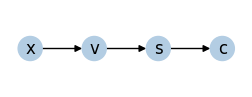

                  Node Information                   
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module                                     ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x    │ InputNode()                                │
│ v    │ InSetOutSetNode(in_set=[10], out_set=[11]) │
│ s    │ CumSumNode(dim=-1)                         │
│ c    │ GreaterThanZeroNode()                      │
└──────┴────────────────────────────────────────────┘

In [68]:
dag1 = DAGModel()


def input_display_value_converter(x: torch.Tensor):
    if x.ndim == 1:
        return str(model.to_str_tokens(x, prepend_bos=False))
    elif x.ndim == 2:
        return str(
            [model.to_str_tokens(x[i], prepend_bos=False) for i in range(x.shape[0])]
        )
    else:
        raise ValueError("Unsupported input dimensionality")

def vis_layout(*args, **kwargs):
    return dict(x=(0,0), v=(1,0), s=(2,0), c=(3,0))

dag1.add_node(
    "x",
    InputNode(display_value_converter=input_display_value_converter),
)
dag1.add_node("v", InSetOutSetNode(open_paren_tokens, closed_paren_tokens))
dag1.add_node("s", CumSumNode())
dag1.add_node("c", GreaterThanZeroNode())

dag1.add_edge("x", "v")
dag1.add_edge("v", "s")
dag1.add_edge("s", "c")

dag1.set_visualization_params(layout=vis_layout, canvas_size=(3, 1))

dag1.visualize()

In [69]:
def string_to_dag_inputs(strings: str | list[str], unsqueeze_batch_dim=False):
    if isinstance(strings, str):
        strings = [strings]
    tokens = model.to_tokens(strings)
    if unsqueeze_batch_dim:
        tokens = tokens.unsqueeze(0)
    return dict(x=tokens)

In [70]:
string1 = "(d(d)d)d"
string2 = "(d)d(d)d"
print("string1 dag input", string_to_dag_inputs(string1))
print("string2 dag input", string_to_dag_inputs(string2))

string1 dag input {'x': tensor([[ 1, 10, 70, 10, 70, 11, 70, 11, 70]])}
string2 dag input {'x': tensor([[ 1, 10, 70, 11, 70, 10, 70, 11, 70]])}


In [71]:
dag1(string_to_dag_inputs([string2]))

{'c': tensor([[False,  True,  True, False, False,  True,  True, False, False]])}

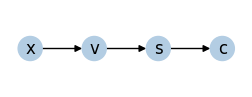

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module                                     ┃ Value                                                       ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x    │ InputNode()                                │ [['<|BOS|>', '(', 'd', ')', 'd', '(', 'd', ')', 'd']]       │
│ v    │ InSetOutSetNode(in_set=[10], out_set=[11]) │ [[0, 1, 0, -1, 0, 1, 0, -1, 0]]                             │
│ s    │ CumSumNode(dim=-1)                         │ [[0, 1, 1, 0, 0, 1, 1, 0, 0]]                               │
│ c    │ GreaterThanZeroNode()                      │ [[False, True, True, False, False, True, True, False,       │
│      │                                            │ False]]                                                     │
└──────┴────────────────────────────────────────────┴─────────────────────────────────────────────────────────────┘

In [72]:
dag1.visualize(display_node_values=True)

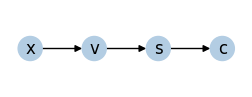

                                                 Node Information                                                  
┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Node ┃ Module                                     ┃ Value                                                       ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ x    │ InputNode()                                │ [['<|BOS|>', '(', 'd', '(', 'd', ')', 'd', ')', 'd']]       │
│ v    │ InSetOutSetNode(in_set=[10], out_set=[11]) │ [[0, 1, 0, -1, 0, -1, 0, -1, 0]]                            │
│ s    │ CumSumNode(dim=-1)                         │ [[0, 1, 1, 0, 0, -1, -1, -2, -2]]                           │
│ c    │ GreaterThanZeroNode()                      │ [[False, True, True, False, False, False, False, False,     │
│      │                                            │ False]]                                                     │
└──────┴────────────────────────────────────────────┴─────────────────────────────────────────────────────────────┘

In [73]:
intervention_v_mask = torch.zeros([1, 2, 9], dtype=torch.bool)
intervention_v_mask[0, 0, 1] = True
intervention_v_mask[0, 1, 3] = True

dag1.run_interchange_intervention(
    base_input=string_to_dag_inputs([string1]),
    source_inputs=string_to_dag_inputs([string1, string2], unsqueeze_batch_dim=True),
    intervention_mask={"v": intervention_v_mask},
)
dag1.visualize(display_node_values=True)

## Variable alignment

In [ ]:
list(model.hook_dict.keys())

['hook_embed',
 'hook_pos_embed',
 'blocks.0.ln1.hook_scale',
 'blocks.0.ln1.hook_normalized',
 'blocks.0.ln2.hook_scale',
 'blocks.0.ln2.hook_normalized',
 'blocks.0.attn.hook_k',
 'blocks.0.attn.hook_q',
 'blocks.0.attn.hook_v',
 'blocks.0.attn.hook_z',
 'blocks.0.attn.hook_attn_scores',
 'blocks.0.attn.hook_pattern',
 'blocks.0.attn.hook_result',
 'blocks.0.mlp.hook_pre',
 'blocks.0.mlp.hook_post',
 'blocks.0.hook_q_input',
 'blocks.0.hook_k_input',
 'blocks.0.hook_v_input',
 'blocks.0.hook_attn_out',
 'blocks.0.hook_mlp_in',
 'blocks.0.hook_mlp_out',
 'blocks.0.hook_resid_pre',
 'blocks.0.hook_resid_mid',
 'blocks.0.hook_resid_post',
 'ln_final.hook_scale',
 'ln_final.hook_normalized']

In [ ]:
def input_alignment(x: torch.tensor, vectorised=False):
    if vectorised:
        return dict(x=to_numpy(x))
    if x.ndim == 1:
        return dict(x=model.to_str_tokens(x))
    elif x.ndim == 2:
        return [
            dict(
                x=model.to_str_tokens(x[i]),
            )
            for i in range(x.shape[0])
        ]
    else:
        raise ValueError("Invalid input shape")


def output_alignment(y: torch.tensor):
    return dict(y=list(to_numpy(torch.argmax(y, dim=-1))))


def output_modifier(y: torch.tensor):
    binary_output = torch.empty(*y.shape[:-1], 2, device=y.device)
    binary_output[..., 0] = y[..., open_paren_tokens].sum(dim=-1)
    binary_output[..., 1] = y[..., closed_paren_tokens].sum(dim=-1)
    
    return F.softmax(binary_output, dim=-1)

variable_alignment = VariableAlignmentTransformer(
    dag=dag1,
    low_level_model=model,
    dag_nodes=["s"],
    input_alignment=input_alignment,
    output_alignment=output_alignment,
    intervene_model_hooks=["blocks.0.hook_resid_mid"],
    subspaces_sizes=[128],
    output_modifier=output_modifier,
    device=device,
    verbosity=1,
)

Running model to determine activation space size...


In [ ]:
model.to_tokens([string1, string2])

tensor([[ 1, 10, 70, 10, 70, 11, 70, 11, 70],
        [ 1, 10, 70, 11, 70, 10, 70, 11, 70]], device='cuda:0')

In [ ]:
dataset = variable_alignment.create_interchange_intervention_dataset(
    model.to_tokens([string1, string2], move_to_device=False), num_samples=10
)
dataset[0]

Creating interchange intervention dataset...


Computing gold outputs: 100%|██████████| 10/10 [00:00<00:00, 2733.34it/s]


(tensor([ 1, 10, 70, 11, 70, 10, 70, 11, 70]),
 tensor([[[ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 10, 70, 11, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70],
          [ 1, 10, 70, 11, 70, 10, 70, 11, 70]]]),
 tensor([[[ 0.1987,  0.2988, -0.2028,  ..., -0.1113,  0.0219, -0.1860],
          [ 0.0716,  0.3524,  0.1183,  ...,  0.0634,  0.1977,  0.0485],
          [ 0.2872,  0.0938,  0.4312,  ...,  0.0091,  0.4367,  0.1501],
          ...,
          [ 0.3341,  0.1542,  0.6004,  ...,  0.0055,  0.5116,  0.2204],
          [-0.0367,  0.3568,  0.1034,  ...,  0.2684,  0.2692, -0.2830],
          [ 0.3733,  0.0024,  0.3274,  ..., -0.0718,  0.6497,  0.1244]],
 
         [[ 0.1987,  0.2988, -0.2028,  ..., -0.1113,  0.0219, -0.186

In [ ]:
output = variable_alignment.run_distributed_interchange_intervention(
    dataset[:][0].to(device), dataset[:][1].to(device), dataset[:][2].to(device)
)

In [ ]:
output.shape

torch.Size([10, 9, 2])

In [ ]:
output.argmax(dim=-1)

tensor([[0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 1, 1, 0, 1, 0, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1]], device='cuda:0')

## Data

In [ ]:
data_df = pd.read_csv(DATA_FILE)

In [ ]:
data_df = data_df[:DATASET_MAX_SIZE]

In [ ]:
data_df.describe()

,text
count,10000
unique,9949
top,.1
freq,18


In [ ]:
data_df.head()

,text
0,disabled = not self._is_active(key)
1,self._widgets[key].append(
2,self._widgets[key].append(.1
3,self._widgets[key].append(.2
4,self._widgets[key].append(.3


In [ ]:
if LOAD_DATA:
    data_tokens = torch.load(TOKENISED_DATA_FILE)
else:
    data_tokens = model.to_tokens(data_df["text"].values, move_to_device=False)

if SAVE_DATA:
    torch.save(data_tokens, TOKENISED_DATA_FILE)

In [ ]:
data_tokens.shape

torch.Size([10000, 95])

In [ ]:
train_tokens = data_tokens[int(TEST_PROPORTION * data_tokens.shape[0]) :]
test_tokens = data_tokens[: int(TEST_PROPORTION * data_tokens.shape[0])]
print("Train tokens shape:", train_tokens.shape)
print("Test tokens shape:", test_tokens.shape)

Train tokens shape: torch.Size([9000, 95])
Test tokens shape: torch.Size([1000, 95])


## Interchange intervention training

In [ ]:
if LOAD_DATA:
    train_ii_dataset = torch.load(TRAIN_II_DATA_FILE)
    test_ii_dataset = torch.load(TEST_II_DATA_FILE)
else:
    train_ii_dataset = variable_alignment.create_interchange_intervention_dataset(
        train_tokens, num_samples=TRAIN_II_DATASET_SIZE
    )
    test_ii_dataset = variable_alignment.create_interchange_intervention_dataset(
        test_tokens, num_samples=TEST_II_DATASET_SIZE
    )

if SAVE_DATA:
    torch.save(train_ii_dataset, TRAIN_II_DATA_FILE)
    torch.save(test_ii_dataset, TEST_II_DATA_FILE)

In [ ]:
losses, accuracies = variable_alignment.train_rotation_matrix(
    ii_dataset=train_ii_dataset, num_epochs=TRAIN_EPOCHS, batch_size=96, lr=100
)

Epoch [1/10]:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch [1/10]: 100%|██████████| 105/105 [07:08<00:00,  4.08s/it]


Loss: 0.77989, Accuracy: 0.41062


Epoch [2/10]: 100%|██████████| 105/105 [06:00<00:00,  3.43s/it]


Loss: 0.76389, Accuracy: 0.43462


Epoch [3/10]: 100%|██████████| 105/105 [07:20<00:00,  4.19s/it]


Loss: 0.75930, Accuracy: 0.44160


Epoch [4/10]: 100%|██████████| 105/105 [05:44<00:00,  3.28s/it]


Loss: 0.75659, Accuracy: 0.44569


Epoch [5/10]: 100%|██████████| 105/105 [06:43<00:00,  3.84s/it]


Loss: 0.75468, Accuracy: 0.44869


Epoch [6/10]: 100%|██████████| 105/105 [06:31<00:00,  3.73s/it]


Loss: 0.75323, Accuracy: 0.45093


Epoch [7/10]: 100%|██████████| 105/105 [07:14<00:00,  4.14s/it]


Loss: 0.75207, Accuracy: 0.45268


Epoch [8/10]: 100%|██████████| 105/105 [06:22<00:00,  3.65s/it]


Loss: 0.75112, Accuracy: 0.45403


Epoch [9/10]: 100%|██████████| 105/105 [07:25<00:00,  4.24s/it]


Loss: 0.75031, Accuracy: 0.45526


Epoch [10/10]: 100%|██████████| 105/105 [07:32<00:00,  4.30s/it]

Loss: 0.74962, Accuracy: 0.45636
